# Test of the path-shadowing using the SPX index data

### Importing necessary libraries

In [53]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

from sklearn.neighbors import KernelDensity

from shadowing import (
    Softmax,
    compute_smile,
    PathShadowing,
    Foveal,
    RelativeMSE,
    PredictionContext,
    ArrayType,
)

### Generating and analyzing different data sets
#### SPX index data

/Users/ghaith/Documents/SCOLAIRE/M2QF/S6/Cutting Edge Project/Project/path-shadowing-monte-carlo/.venv/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


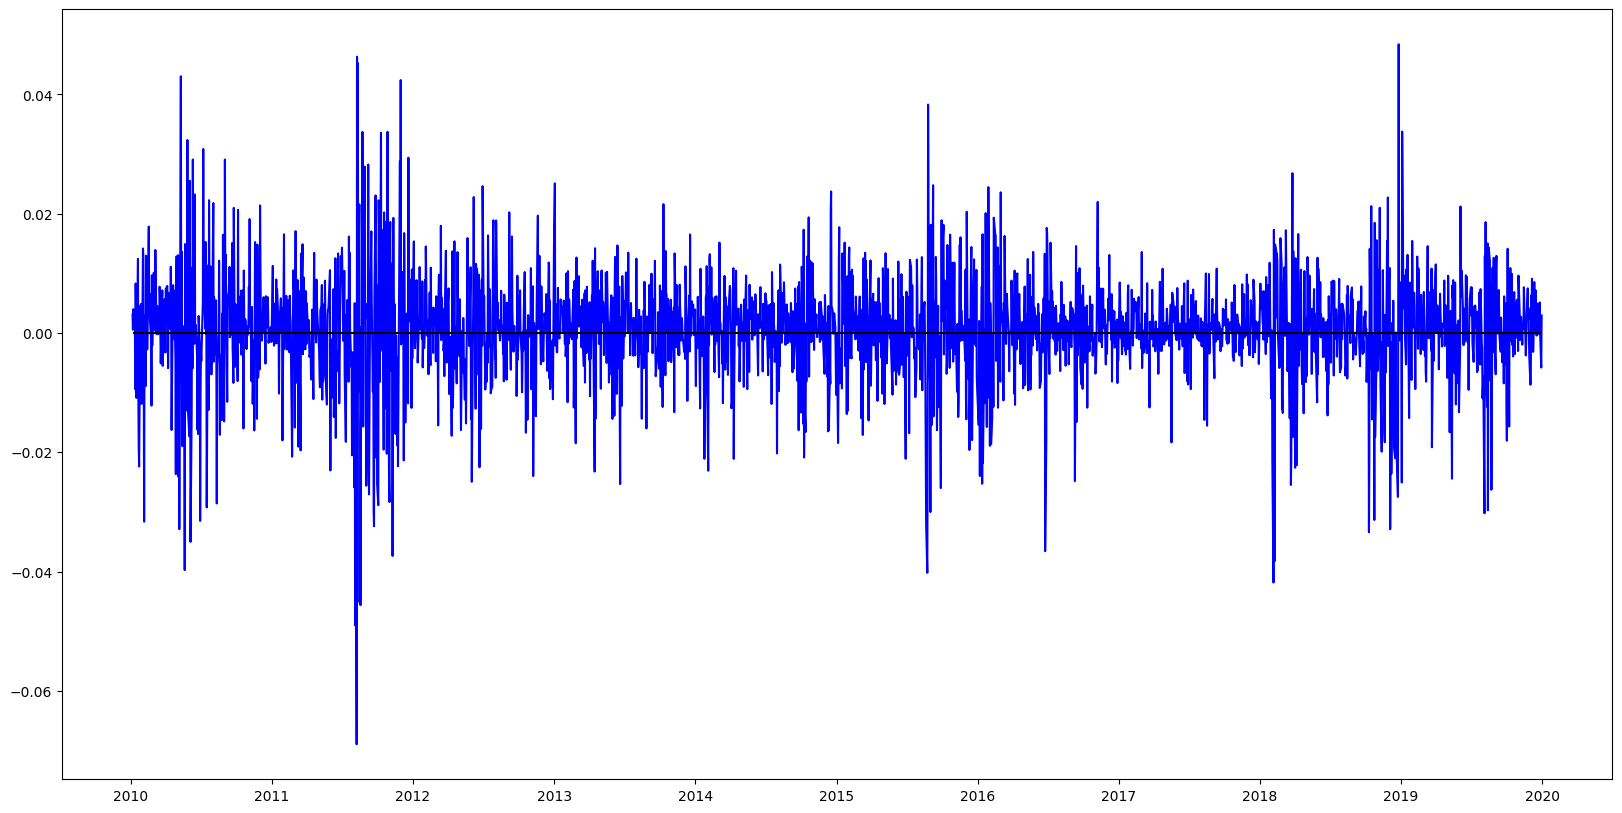

In [44]:
#importing SPX data from yahoo finance from 2010 to 2020
spx = yf.download('^GSPC','2010-01-01','2020-01-01')
#log returns of the adjusted close price
spx['log_returns'] = np.log(spx['Adj Close']/spx['Adj Close'].shift(1))
#removing the first row with NaN
spx = spx.iloc[1:]
#plotting the log returns
plt.figure(figsize=(20,10))
plt.plot(spx['log_returns'], color='blue')
plt.hlines(y=0, xmin=spx.index[0], xmax=spx.index[-1], color='black')

**Standard statics of log-returns in the SPX index observed in the period 2000-2019**

In [52]:
#standard statistics of the log returns
spx['log_returns'].describe()

count    2515.000000
mean        0.000417
std         0.009317
min        -0.068958
25%        -0.003272
50%         0.000593
75%         0.005029
max         0.048403
Name: log_returns, dtype: float64

/var/folders/zw/dpjp09bn4_l8yjw9zyyrfcmr0000gn/T/ipykernel_21115/543516160.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p, 'k', linewidth=2, color='red')


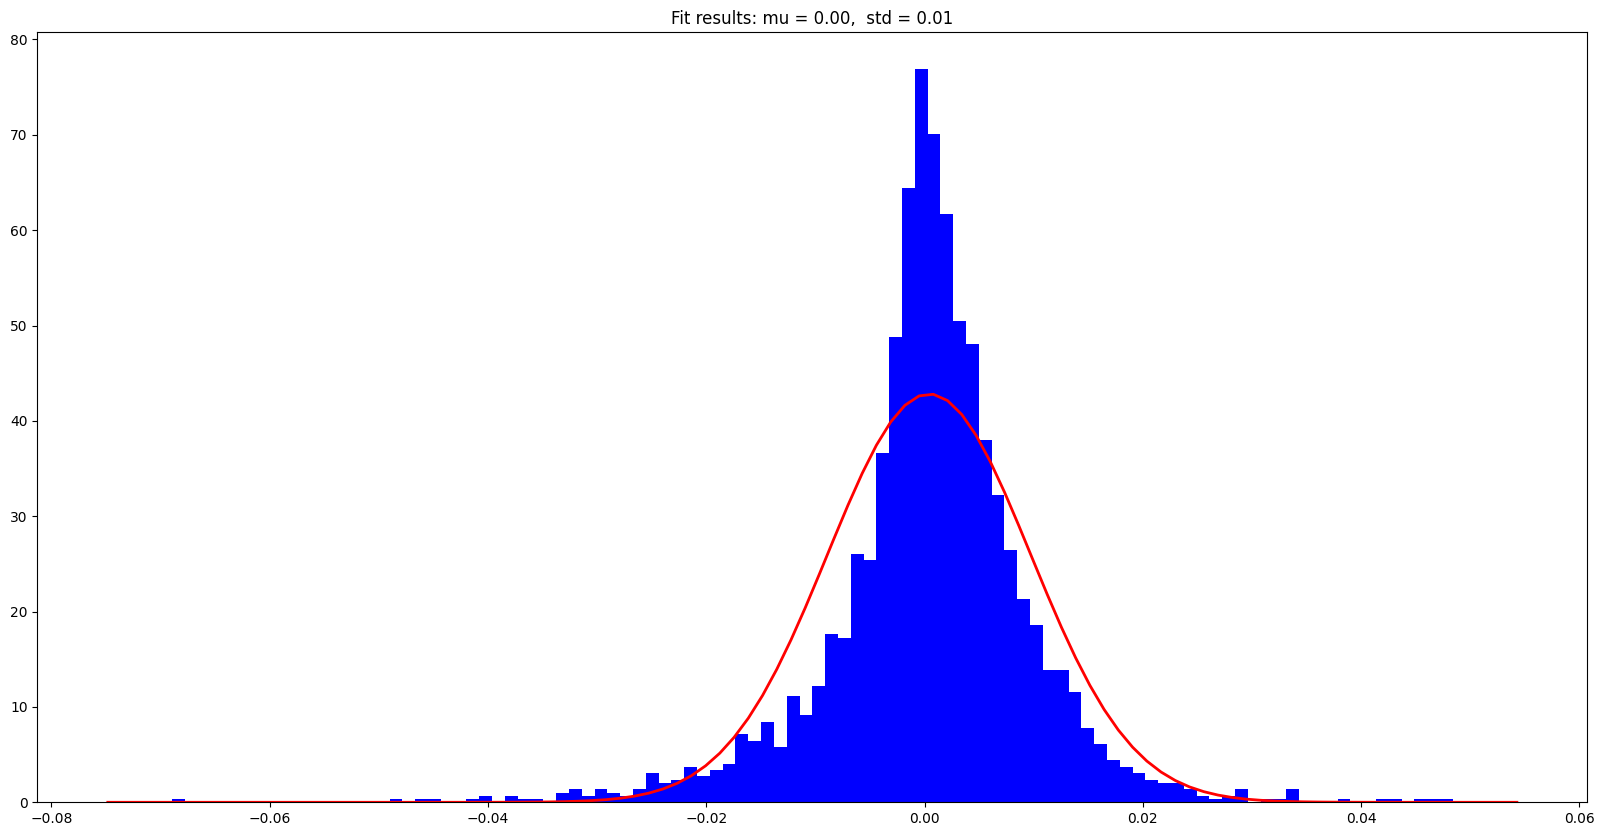

In [79]:
#histogram of the log returns with xmin and xmax between -0.05 and 0.05
plt.figure(figsize=(20,10))
plt.hist(spx['log_returns'], bins=100, density=True, color='blue', range=(-0.05,0.05))
#fit a gaussian distribution to the log returns and plot it
mu, std = norm.fit(spx['log_returns'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, color='red')
plt.title("Fit results: mu = %.2f,  std = %.2f" % (mu, std))
plt.show()